In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import cpi
from sklearn import tree
import warnings
from IPython.display import Image
import pydotplus
import graphviz
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics

**Data Set Information:**

See link for descriptions of features. Description in link detailed below.

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29


*From link:* Database contains records for 1885 respondents. For each respondent 12 attributes are known: Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), and ImpSS (sensation seeking), level of education, age, gender, country of residence and ethnicity. All input attributes are originally categorical and are quantified. After quantification values of all input features can be considered as real-valued. In addition, participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day.

In [70]:
drug_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\drug_consumption.data', header =  None,
                     names = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA'])

col = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']
d_col = ['Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron']
p_col = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
c_col = d_col + p_col

for c in col:
    drug_df[c] = drug_df[c].astype(str).apply(lambda x: x[:8] if x[0] == '-' else x[:7])

equiv1 = {'-0.95197':'18-24', '-0.07854':'25-34', '0.49788':'35-44', '1.09449':'45-54', '1.82213':'55-64', '2.59171':'65+'}
equiv2 = {'0.48246':'Female', '-0.48246':'Male'}
equiv3 = {'-2.43591':'Left Before 16', '-1.7379':'Left at 16', '-1.43719':'Left at 17', '-1.22751':'Left at 18', '-0.61113':'Some College', '-0.05921':'Professional Certificate/Diploma', '0.45468':'College Degree', '1.16365':'Masters Degree', '1.98437':'Doctorate Degree'}
equiv4 = {'-0.09765':'Australia', '0.24923':'Canada', '-0.46841':'New Zealand', '-0.28519':'Other', '0.21128':'Republic of Ireland', '0.96082':'UK', '-0.57009':'USA'}
equiv5 = {'-0.50212':'Asian', '-1.10702':'Black', '1.90725':'Mixed-Black/Asian', '0.126':'Mixed-White/Asian', '-0.22166':'Mixed-White/Black', '0.1144':'Other', '-0.31685':'White'}
# equiv6 = {'CL0':'Never', 'CL1':'10+ years', 'CL2':'Last 10 years', 'CL3':'Last year', 'CL4':'Last month', 'CL5':'Last week', 'CL6':'Last Day'}
equiv6 = {'CL0':'No', 'CL1':'Yes', 'CL2':'Yes', 'CL3':'Yes', 'CL4':'Yes', 'CL5':'Yes', 'CL6':'Yes'}

drug_df['Age'] = drug_df['Age'].map(equiv1)
drug_df['Gender'] = drug_df['Gender'].map(equiv2)
drug_df['Education'] = drug_df['Education'].map(equiv3)
drug_df['Country'] = drug_df['Country'].map(equiv4)
drug_df['Ethnicity'] = drug_df['Ethnicity'].map(equiv5)

for c in d_col:
    drug_df[c] = drug_df[c].map(equiv6)

drug_df = drug_df.drop('VSA', axis = 1)

print(drug_df.head())

   ID    Age  Gender                         Education Country  \
0   1  35-44  Female  Professional Certificate/Diploma      UK   
1   2  25-34    Male                  Doctorate Degree      UK   
2   3  35-44    Male  Professional Certificate/Diploma      UK   
3   4  18-24  Female                    Masters Degree      UK   
4   5  35-44  Female                  Doctorate Degree      UK   

           Ethnicity   Nscore   Escore   Oscore   Ascore  ...  Crack  Ecstasy  \
0  Mixed-White/Asian  0.31287 -0.57545 -0.58331 -0.91699  ...     No       No   
1              White -0.67825  1.93886  1.43533  0.76096  ...    Yes       No   
2              White -0.46725  0.80523 -0.84732 -1.62090  ...     No       No   
3              White -0.14882 -0.80615 -0.01928  0.59042  ...     No       No   
4              White  0.73545 -1.63340 -0.45174 -0.30172  ...    Yes       No   

   Heroin Ketamine Legalh  LSD Meth Mushrooms Nicotine Semeron  
0      No       No     No   No   No       Yes      

In [71]:
drug_df.describe()

,ID,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [72]:
for column in c_col:
    le = LabelEncoder()
    drug_df[column] = le.fit_transform(drug_df[column])

In [73]:
drug_df.dtypes

ID            int64
Age          object
Gender       object
Education    object
Country      object
Ethnicity    object
Nscore        int64
Escore        int64
Oscore        int64
Ascore        int64
Cscore        int64
Impulsive     int64
SS            int64
Acohol        int32
Alcohol       int32
Amphet        int32
Amyl          int32
Benzos        int32
Caffeine      int32
Cannabis      int32
Chocolate     int32
Cocaine       int32
Crack         int32
Ecstasy       int32
Heroin        int32
Ketamine      int32
Legalh        int32
LSD           int32
Meth          int32
Mushrooms     int32
Nicotine      int32
Semeron       int32
dtype: object

In [74]:
drug_df.isna().sum()

ID           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
Ascore       0
Cscore       0
Impulsive    0
SS           0
Acohol       0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caffeine     0
Cannabis     0
Chocolate    0
Cocaine      0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semeron      0
dtype: int64

Text(0.5, 1.0, 'SS')

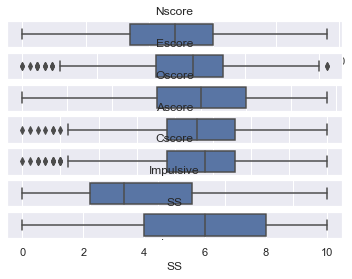

<Figure size 1440x720 with 0 Axes>

In [75]:
f, axes = plt.subplots(7, 1)

plt.figure(figsize=(20, 10))
plt.tight_layout()

sns.boxplot(x = drug_df['Nscore'], ax = axes[0]).set_title('Nscore')
sns.boxplot(x = drug_df['Escore'], ax = axes[1]).set_title('Escore')
sns.boxplot(x = drug_df['Oscore'], ax = axes[2]).set_title('Oscore')
sns.boxplot(x = drug_df['Ascore'], ax = axes[3]).set_title('Ascore')
sns.boxplot(x = drug_df['Cscore'], ax = axes[4]).set_title('Cscore')
sns.boxplot(x = drug_df['Impulsive'], ax = axes[5]).set_title('Impulsive')
sns.boxplot(x = drug_df['SS'], ax = axes[6]).set_title('SS')

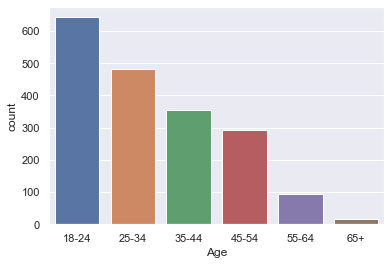

In [76]:
age_index = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
sns.countplot(x = drug_df['Age'], order = age_index)

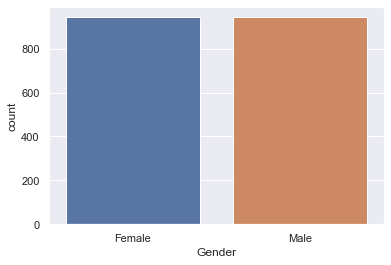

In [77]:
sns.countplot(x = drug_df['Gender'])

[Text(0, 0, 'UK'),
 Text(0, 0, 'Canada'),
 Text(0, 0, 'USA'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'Republic of Ireland'),
 Text(0, 0, 'New Zealand')]

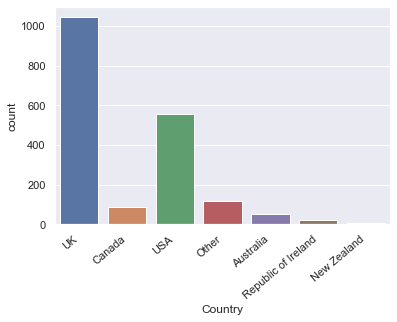

In [78]:
country_cnt = sns.countplot(x = drug_df['Country'])
country_cnt.set_xticklabels(country_cnt.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'Left Before 16'),
 Text(0, 0, 'Left at 16'),
 Text(0, 0, 'Left at 17'),
 Text(0, 0, 'Left at 18'),
 Text(0, 0, 'Some College'),
 Text(0, 0, 'Professional Certificate/Diploma'),
 Text(0, 0, 'College Degree'),
 Text(0, 0, 'Masters Degree'),
 Text(0, 0, 'Doctorate Degree')]

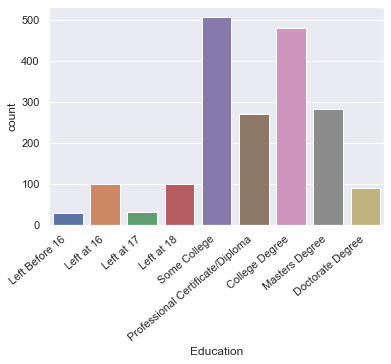

In [79]:
ed_index = ['Left Before 16', 'Left at 16', 'Left at 17', 'Left at 18', 'Some College', 'Professional Certificate/Diploma', 'College Degree', 'Masters Degree', 'Doctorate Degree']
ed_cnt = sns.countplot(x = drug_df['Education'], order = ed_index)
ed_cnt.set_xticklabels(ed_cnt.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'Mixed-White/Asian'),
 Text(0, 0, 'White'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Mixed-White/Black'),
 Text(0, 0, 'Asian'),
 Text(0, 0, 'Black'),
 Text(0, 0, 'Mixed-Black/Asian')]

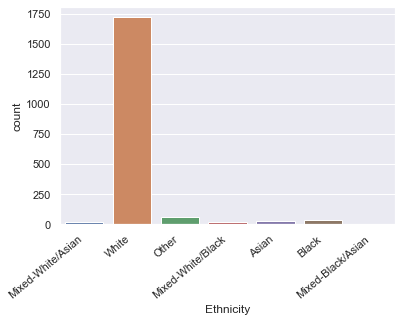

In [80]:
eth_cnt = sns.countplot(x = drug_df['Ethnicity'])
eth_cnt.set_xticklabels(eth_cnt.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, '0'), Text(0, 0, '1')]

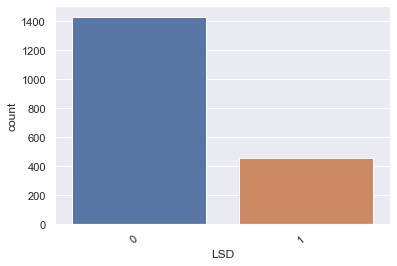

In [89]:
# msh_cnt = sns.countplot(x = drug_df['Alcohol'], order = freq_index)
msh_cnt = sns.countplot(x = drug_df['LSD'])
# msh_cnt = sns.countplot(x = drug_df['Mushrooms'])
msh_cnt.set_xticklabels(msh_cnt.get_xticklabels(), rotation=40, ha="right")

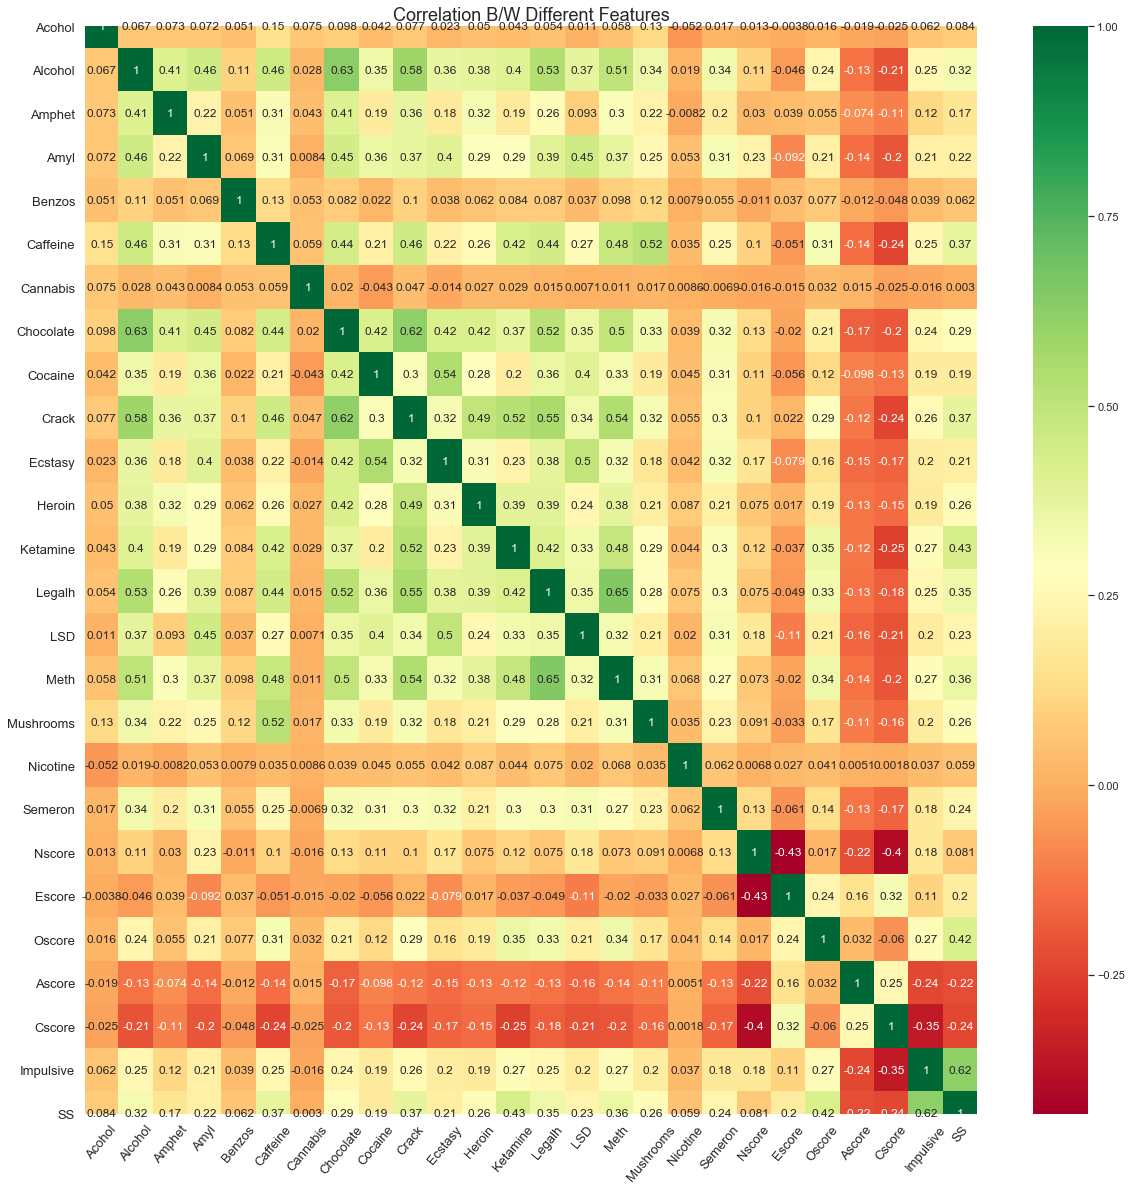

In [82]:
corrmat = drug_df[c_col].corr()

# print(corrmat)
plt.figure(figsize=(20,20))

sns.set(font_scale=1)
hm = sns.heatmap(corrmat,cmap = 'RdYlGn',annot=True,
             yticklabels = c_col, xticklabels = c_col)
plt.xticks(fontsize=13,rotation=50)
plt.yticks(fontsize=13)
plt.title("Correlation B/W Different Features",fontsize=18)
plt.show()

In [31]:
print(d_col)

['Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA']


**Below I'm setting up the training/target sets**

In [117]:
freq_index = ['Never', '10+ years', 'Last 10 years', 'Last year', 'Last month', 'Last week', 'Last Day']

# cat_feat = ['Age', 'Gender', 'Education']
cat_feat = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Cannabis']
num_feat = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
msh_class = drug_df['Alcohol'].unique()


X1 = drug_df[cat_feat]
X2 = drug_df[num_feat]
X3 = drug_df[cat_feat + num_feat]
Y = drug_df['LSD']


for c in cat_feat:
    X2 = pd.concat([X2, pd.get_dummies(drug_df[c], drop_first=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.2, random_state = 465)

In [118]:
# print(drug_df.head())

**KNN**

In [119]:
print(num_feat)

['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [129]:
X_k = drug_df[['Impulsive', 'Oscore']]

X_train, X_test, y_train, y_test = train_test_split(X_k, Y, test_size = 0.2, random_state = 465)

neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train,y_train)
y_pred = neighbors.predict(X_test)

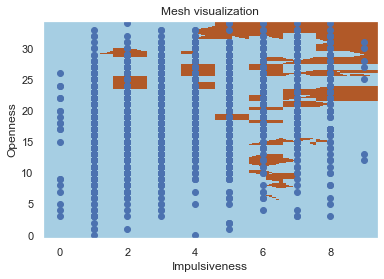

In [126]:
# Mesh size.
h = 0.1

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X_k.iloc[:, 0].min() - .5
x_max = X_k.iloc[:, 0].max() + .5
y_min = X_k.iloc[:, 1].min() - .5
y_max = X_k.iloc[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)

# print(xx)
# print(yy)
# print(Z)

plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X_k.iloc[:, 0], X_k.iloc[:, 1])
plt.xlabel('Impulsiveness')
plt.ylabel('Openness')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

In [130]:
print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ", 
    classification_report(y_test, y_pred)) 

Confusion Matrix:  [[255  27]
 [ 80  15]]

Accuracy :  71.61803713527851

Report :                precision    recall  f1-score   support

           0       0.76      0.90      0.83       282
           1       0.36      0.16      0.22        95

    accuracy                           0.72       377
   macro avg       0.56      0.53      0.52       377
weighted avg       0.66      0.72      0.67       377



**SVM**

In [103]:
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Non-User','User']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
def report_performance(model):

    model_test = model.predict(X_test)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)

In [105]:
svm = SVC(kernel="rbf", C=2,random_state=0)
svm.fit(X_train, y_train.ravel())
y_pred = svm.predict(X_test)

# cross_val_score(rfc, X_test, y, cv=5)
print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ", 
    classification_report(y_test, y_pred)) 

Confusion Matrix:  [[325  31]
 [ 98  18]]

Accuracy :  72.66949152542372

Report :                precision    recall  f1-score   support

           0       0.77      0.91      0.83       356
           1       0.37      0.16      0.22       116

    accuracy                           0.73       472
   macro avg       0.57      0.53      0.53       472
weighted avg       0.67      0.73      0.68       472



**Decision Tree**

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.2, random_state = 465)
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state = 465
)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)



# Render our tree.
# dot_data = tree.export_graphviz(
#     decision_tree, out_file=None,
#     feature_names=X2.columns,
#     class_names=msh_class,
#     filled=True
# )
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())



print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
      
print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
print("Report : ", 
    classification_report(y_test, y_pred)) 

Confusion Matrix:  [[224  58]
 [ 54  41]]
Accuracy :  70.29177718832891
Report :                precision    recall  f1-score   support

           0       0.81      0.79      0.80       282
           1       0.41      0.43      0.42        95

    accuracy                           0.70       377
   macro avg       0.61      0.61      0.61       377
weighted avg       0.71      0.70      0.70       377



**Random Forest**

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.25, random_state = 465)
rfc = ensemble.RandomForestClassifier(n_estimators = 500, random_state = 465)
rfc.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "criterion": ["gini", "entropy"]}

# # run grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

y_pred = grid_search.predict(X_test)

# cross_val_score(rfc, X_test, y, cv=5)
print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ", 
    classification_report(y_test, y_pred)) 

GridSearchCV took 232.24 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.783 (std: 0.019)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.781 (std: 0.017)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.779 (std: 0.020)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.779 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2}

Accuracy :  79.66101694915254
Report :                precision    recall  f1-score   support

           0       0.81      0.96      0.88       356
           1       0.70      0.30      0.42       116

    accuracy                           0.80       472
   macro avg       0.75      0.6